<h2>H.O.G. and SVM Image Classification with OpenCV 


***


## Import Important Libraries and Define Auxilary Functions


Libraries for data processing and visualization:


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

Libraries for image pre-processing and classification:


In [2]:
import cv2
import joblib
#from sklearn.utils import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV



Libraries for OS:


In [3]:
import os


In [4]:
def load_images(image_paths):
# loop over the input images
    for (i, image_path) in enumerate(image_paths):
        #read image
        image = cv2.imread(image_path)
        image = np.array(image).astype('uint8')
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_images = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        #label image using the annotations
        label = class_object.index(annotations["annotations"][image_path[7:]][0]['label'])
        train_images.append(hog_features)
        train_labels.append(label)


Get the annotations from _annotation.json file:


In [5]:
#annotations = cvstudioClient.get_annotations()
import json
with open('images/_annotations.json', 'r') as f:
    annotations = json.load(f)
image_dir = 'images'
image_files = os.listdir(image_dir)

# Select a random image file
random_filename = os.path.join(image_dir, random.choice(image_files))

# Get the annotation for the selected image file
annotation = annotations['annotations'][os.path.basename(random_filename)]

# Print the random annotation
print(annotation)


image_paths = [os.path.join('images', filename) for filename in os.listdir('images') if filename.endswith('.jpg')]

[{'label': 'left', 'id': '81028c98-4032-4078-8358-4bfa8e04ac5c'}]


## Histogram of Oriented Gradients (H.O.G.)


H.O.G. generates a histogram for each localized region. We will pick a random image and see how H.O.G. works.


In [6]:

sample_image = cv2.imread(random_filename)

Resize the image to a smaller size to allow the algorithm to run faster and convert the images to the grayscale to reduce the number of channels. to reduce computational complexities

In [7]:
sample_image = cv2.resize(sample_image, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

Plot the data to look at what it looks like:


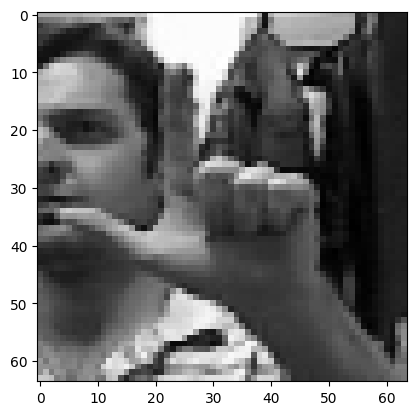

In [8]:
plt.imshow(sample_image, cmap=plt.cm.gray)


H.O.G. stands for Histogram of Oriented Gradients. It uses the gradient orientation of the localized regions of an image and generates a histogram for each localized region.


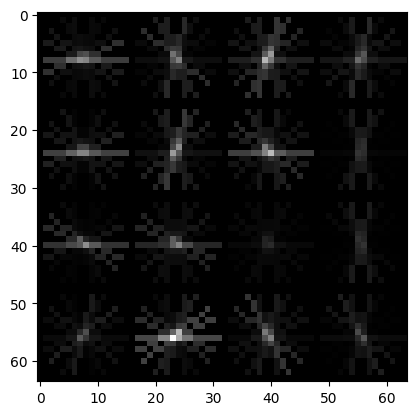

In [9]:
## when we run H.O.G., it returns an array of features and the image/output it produced
## the featurre is what we use to train the SVM model
sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## lets look at what the H.O.G. feature looks like
plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


Initiate a location for saving loaded images:


In [10]:
image_paths = list(paths.list_images('images'))
train_images = []
train_labels = []
class_object = annotations['labels']

Use the function on the image path:


In [11]:
load_images(image_paths)

Create an array of the images and use the <code>np.vstack</code> to vertically stack arrays for wrangling.


In [12]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

We will <code>reshape</code> the array to <code>(label size, 1)</code>. The array will look like this: <code>\[\[1], \[0], ..., \[0]]</code></p>


In [13]:
labels_array = np.array(train_labels)

In [14]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

Concatenate the images and labels:


In [15]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

Divide the data into a training and test set:


In [16]:
percentage = 75
partition = int(len(train_df)*percentage/100)

In [17]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

In [53]:
#added data to divide our datset    # added another method to check wheter the model is overfitting or not
#added lib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

percentage = 75
partition = int(len(train_df)*percentage/100)

x_train, x_test, y_train, y_test = train_test_split(train_df[:, :-1], train_df[:, -1], test_size=(100-percentage)/100, random_state=42, stratify=train_df[:, -1])

## Hyperparameters


The kernel type to be used is a hyperparameter. The most common kernels are <code>RBF</code>, <code>poly</code>, or <code>sigmoid</code>. 

<code>C</code> behaves as a regularization parameter in the SVM. The <code>C</code> parameter trades off correct classification of the training examples against the maximization of the decision function’s margin. For larger values of <code>C</code>, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower <code>C</code> will encourage a larger margin, therefore a simpler decision function at the cost of accuracy. We select C and the best kernel by using the validation data.


The  python dictionary <code>param_grid</code>  has different kernels and values of C. We can test them using the validation data.


In [18]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

<code>gamma</code> is a parameter of the RBF kernel and can be thought of as the spread of the kernel and, therefore, the decision region. Low values mean ‘far’ and high values mean ‘close’. The behaviour of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself. We create a Support Vector Classification object.


## Support Vector Machines


In [19]:
base_estimator = SVC(gamma='scale')

We will train the model and try different kernels and parameter values using the function <code>GridSearchCV</code>. The resulting output will be the model that performs best on the validation data.


In [20]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

{'C': 1, 'kernel': 'linear'}
Accuracy: 1.0
1.3053574562072754


In [21]:
#added code
train_score = svm.score(x_train, y_train)
test_score = svm.score(x_test, y_test)

# Print the accuracy scores
print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 1.0
Test Accuracy: 1.0


In [22]:
label_names = [0, 1, 2, 3]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

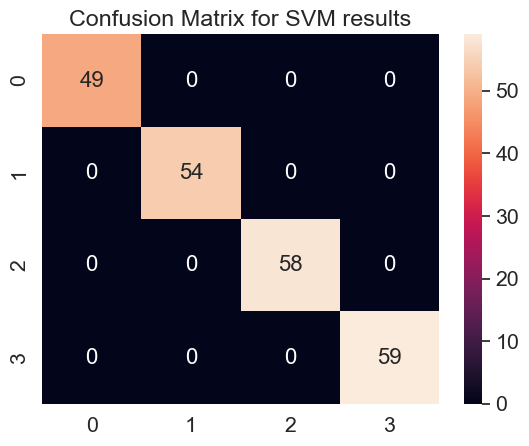

In [27]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()



In [26]:
# Save the SVM model to a file
joblib.dump(svm.best_estimator_, 'svm.joblib')

['svm.joblib']

## Using the Classifier


In [24]:
svm = joblib.load('svm.joblib')

In [25]:
def run_svm(image):
    ## show the original image
    
    
    image= cv2.resize(image,(148,113))
    orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(orig_image)
    plt.show()
    print('\n')
    ## convert the image into a numpy array
    image = np.array(image).astype('uint8')
    ## resize the image to a size of choice
    image = cv2.resize(image, (64, 64))
    ## convert to grayscale to reduce the information in the picture
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ## extract H.O.G features
    hog_features, hog_image = hog(grey_image,
                          visualize=True,
                          block_norm='L2-Hys',
                          pixels_per_cell=(16, 16))
    ## convert the H.O.G features into a numpy array
    image_array = np.array(hog_features)
    ## reshape the array
    image_array = image_array.reshape(1, -1)
    ## make a prediction
    svm_pred = svm.predict(image_array)
    ## print the classifier
    print('Your image was classified as a ' + str(annotations['labels'][int(svm_pred[0])]))
       
    

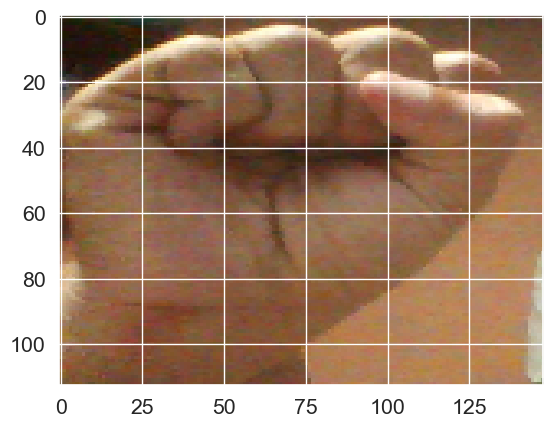



Your image was classified as a stop


In [28]:
## uploading the image
my_image = cv2.imread("stop.png")
## run the above function on the image to get a classification
run_svm(my_image)

added coded to check classifier in real time but its not working as it should

In [ ]:
#added code

def run_svm(image,threshold=0.5):
    ## show the original image
    
    
    image= cv2.resize(image,(148,113))
    orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(orig_image)
   # plt.show()
    print('\n')
    ## convert the image into a numpy array
    image = np.array(image).astype('uint8')
    ## resize the image to a size of choice
    image = cv2.resize(image, (64, 64))
    ## convert to grayscale to reduce the information in the picture
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ## extract H.O.G features
    hog_features, hog_image = hog(grey_image,
                          visualize=True,
                          block_norm='L2-Hys',
                          pixels_per_cell=(16, 16))
    ## convert the H.O.G features into a numpy array
    image_array = np.array(hog_features)
    ## reshape the array
    image_array = image_array.reshape(1, -1)
    ## make a prediction
    svm_pred = svm.predict(image_array)
    ## print the classifier
   #print('Your image was classified as a ' + str(annotations['labels'][int(svm_pred[0])]))
    #print('label=  ' + str(annotations['labels'][int(svm_pred[0])]))  
    max_prob_idx = np.argmax(svm_pred)
    max_prob = svm_pred[max_prob_idx]
    pred_label = annotations['labels'][max_prob_idx]
    ## return the predicted label if its probability is above the threshold, otherwise return a default label
    return pred_label if max_prob >= threshold else "Unknown"   





import cv2
cap = cv2.VideoCapture(0)

## check if the video capture object is opened successfully
if not cap.isOpened():
    print("Unable to open video capture")

## define the region of interest
top_left = (200, 100)
bottom_right = (500, 400)

while True:
    ## read a frame from the webcam
    ret, frame = cap.read()
    
    ## check if the frame is captured successfully
    if not ret:
        print("Unable to capture frame")
        break
    
    ## draw a green rectangle around the region of interest
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
    
    ## crop the frame to the region of interest
    roi = frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    
    ## show the cropped image
    cv2.imshow('ROI', roi)
    
    ## classify the image using the SVM classifier
    pred_label = run_svm(roi,threshold=0.7)
    
    ## draw the predicted label on the frame
    cv2.putText(frame, pred_label, (top_left[0], top_left[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    ## show the frame with the predicted label
    cv2.imshow('Frame', frame)
    
    ## exit if 'q' is pressed
    if cv2.waitKey(1) == ord('q'):
        break

## release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()